In [1]:
import pandas as pd
df = pd.read_csv('yale.csv')
df.head()

,Unnamed: 0,Title,Content
0,0,Extreme Weather Events Have Increased Signific...,[<p>The authors of the report said the finding...
1,1,Mining Taking Place on More Than 20 Percent of...,[<p>Mining activities — both large-scale legal...
2,2,New Super-Enzyme Can Break Down Plastic at Rap...,[<p>A super-enzyme that degrades plastic bottl...
3,3,"As Climate Impacts Worsen, Homeowners Struggle...",[<p>Insurance is getting harder for some U.S. ...
4,4,Human Activity is Increasing Severity and Freq...,[<p>Marine heatwaves have become more than 20 ...


In [2]:
temp = []
for i in df['Content']:
    i = (i.replace('<p>','')).strip('][')
    i = i.replace("</p>","")
    i = i.replace("</a>","")
    i = i.replace("/n","")
    temp.append(i.replace("<a>",""))
temp
df['Content'] = temp

In [51]:
# General
import os
import re
import sklearn
import nltk
import numpy as np
import contractions
import pickle
# Preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
# models
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist
# Plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn
import seaborn as sns
# Enable inline plotting  
%matplotlib inline

In [52]:
corpus = df['Content']
def featureextraction(corpus):
    
    vectorizer = TfidfVectorizer(max_df=.5,min_df=1,max_features=None,ngram_range=(1, 2),norm=None,binary=True,
                             use_idf=False,sublinear_tf=False,strip_accents = 'unicode',stop_words = 'english')
    vectorizer = vectorizer.fit(corpus)
    tfidf = vectorizer.transform(corpus)
    vocab = vectorizer.get_feature_names()

    return tfidf, vocab

In [53]:
tfidf, vocab = featureextraction(corpus)

In [54]:
len(vocab)

3208

In [55]:
np.shape(tfidf)

(10, 3208)

In [56]:
pca = PCA(n_components=10).fit_transform(tfidf.todense())

In [57]:
Z = fastcluster.linkage_vector(pca,method='ward', metric='euclidean')

In [58]:
Z_dataFrame = pd.DataFrame(data=Z, 
    columns=['clusterOne','clusterTwo','distance','newClusterSize'])

In [59]:
from scipy.cluster.hierarchy import fcluster

distance_threshold = 20
clusters = fcluster(Z, distance_threshold, criterion='distance')

In [60]:
len(clusters)

10

In [15]:
from collections import Counter

In [16]:
count = Counter(clusters)

In [17]:
count

Counter({1: 2, 9: 1, 6: 1, 4: 1, 7: 1, 2: 1, 5: 1, 8: 1, 3: 1})

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    df.columns = labels

    for i,r in df.iterrows():
        label_new = list(df.columns[np.argsort(df.iloc[i-1])])
        dd = pd.DataFrame([np.argsort(df.iloc[i-1])],columns=label_new)
        wordcloud = WordCloud(background_color = 'white')
        wordCloud = wordcloud.generate_from_frequencies(dd.iloc[0,-200:])
        plt.figure(figsize=(8, 8))
        plt.imshow(wordCloud)
        plt.axis("off")
        
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))


Cluster 1
affecting,affecting 370,tree loss,tree,report director,transit 30,resources,transit,report said,report world,total mining,total,early,climate change,early warnings,climate,times higher,report industry,00,report

Cluster 2
future,owned consortium,owned,machangara,machangara norcay,major,reuters,major mining,reuters com,city cuenca,city,rich,rich ecuadorean,right,right vote,mandatory,rio,rio blanco,tomebamba,reserves gold

Cluster 3
modeling,modeling say,bit,bit hope,scientists warned,months,shrinking 12,shrinking,shifting response,shifting click,shifting,seen middle,seen,national,national center,sea ice,nations,sea,months year,zones shifting

Cluster 4
century temperatures,goals absolute,goals,goal paris,goal,globe lasting,action,action marine,globe,action research,global temperatures,global,species,species ecosystems,activity,pacific ocean,activity burning,pacific,celsius average,referred

Cluster 5
according new,according study,coauthor new,coauthor,like,emerging market,eme

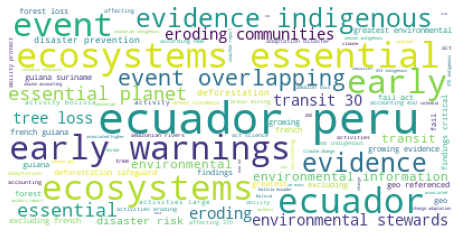

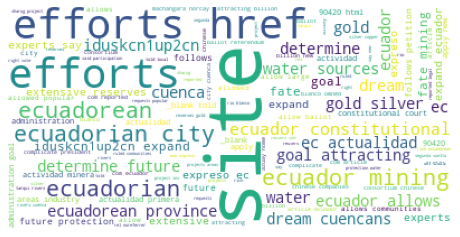

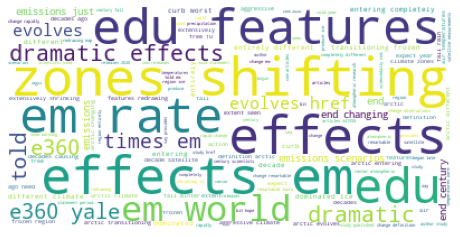

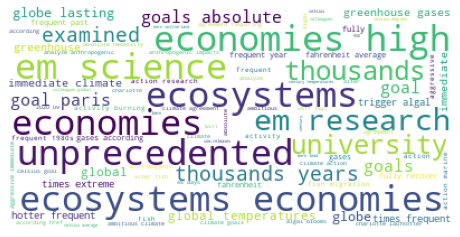

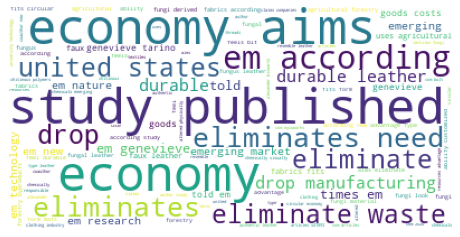

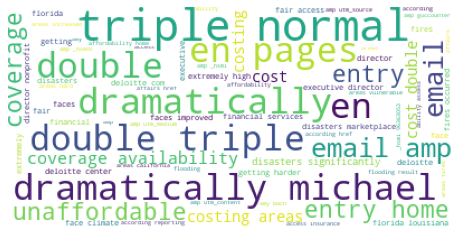

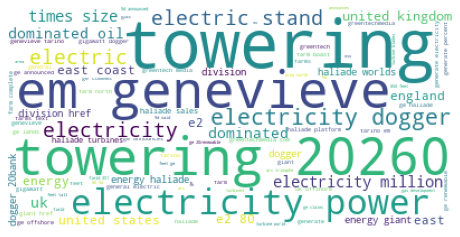

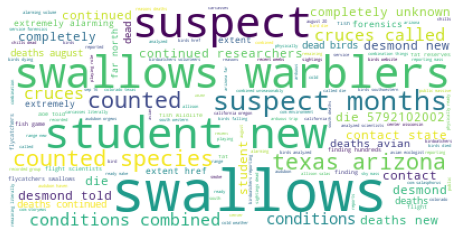

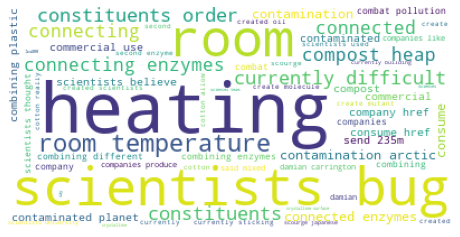

In [24]:
get_top_keywords(tfidf, clusters, vocab, 20)

<AxesSubplot:title={'center':'Top 20 bigrams - Global'}, xlabel='ReviewText'>

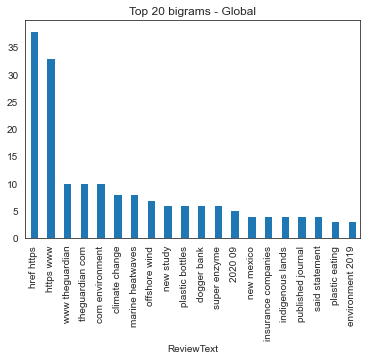

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(corpus, 20)
df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df4.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Bigrams - USA')

In [26]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
def plot_trigrams(common_words,title):
    import matplotlib
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    matplotlib.rcParams['legend.fontsize'] = 60
    plt.style.use('ggplot')
    sns.set_style('ticks')
    
    df6 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
    df6.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
        kind='bar', title='Trigrams-India')
    plt.tight_layout()
    ax.yaxis.grid(which='major',linestyle=':', linewidth='0.5', color='black')

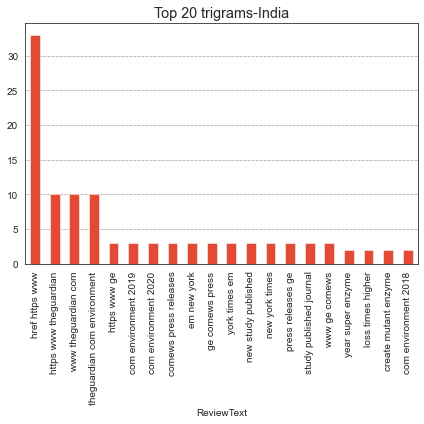

In [27]:
common_words = get_top_n_trigram(corpus, 20)
plot_trigrams(common_words,'USA')

In [28]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from collections import defaultdict
from nltk.corpus import stopwords 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
def bigram_coocurrence(corp):
    stopset = set(stopwords.words('english')) 
    filter_stops = lambda w: len(w) < 3 or w in stopset
    bi_dict = defaultdict(int)
    bg_measures = BigramAssocMeasures()
    for readme in corp:
        words = nltk.word_tokenize(readme)
        bi_finder = BigramCollocationFinder.from_words(words)
        bi_finder.apply_word_filter(filter_stops) 
        bi_collocs = bi_finder.nbest(bg_measures.likelihood_ratio, 10)    
        for colloc in bi_collocs:
            bi_dict[colloc] += 1       
    return bi_dict
def colocate_clouds(corp,title):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    bi_dict = bigram_coocurrence(corp)        
    dd = pd.DataFrame.from_dict(bi_dict,orient='index',dtype='str')
    dff = dd.T
    dff.columns = [str(" ".join(x)) for x in list(dff.columns)]
    dff = dff.astype(int)
    dff = dff.sort_values(by=0,ascending=True, axis=1) 
    wordcloud = WordCloud(background_color = 'white',width=1600, height=800)
    wordCloud = wordcloud.generate_from_frequencies(dff.iloc[0,-200:])
    plt.imshow(wordCloud)
    plt.axis("off")

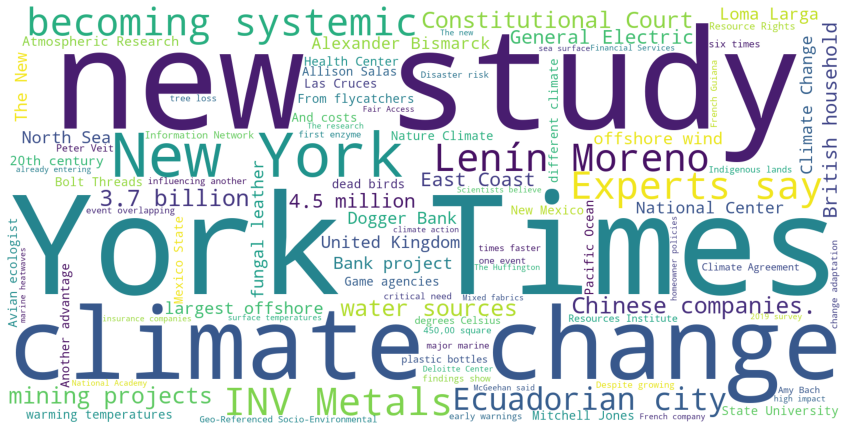

In [29]:
colocate_clouds(corpus,'USA')

In [30]:
import networkx as nx
import matplotlib
def graph_plots(s,title):
    matplotlib.rcParams['legend.fontsize'] = 9
    plt.style.use('ggplot')
    sns.set_style('ticks')
    G = nx.Graph()
    for k, v in s.items():
        G.add_edge(k[0], k[1], weight=(v * 10))
    fig, ax = plt.subplots(figsize=(15, 10))

    pos = nx.spring_layout(G, k=2)

    nx.draw_networkx(G, pos,
                     font_size=16,
                     width=3,
                     edge_color='grey',
                     node_color='purple',
                     with_labels = False,
                     ax=ax)
    for key, value in pos.items():
        x, y = value[0]+.05, value[1]+.03
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='red', alpha=0.25),
                horizontalalignment='center', fontsize=16)
    plt.tight_layout()
    plt.show()

In [31]:
bi_dict_India = bigram_coocurrence(corpus)

In [32]:
s_India = dict(sorted(bi_dict_India.items(), key=lambda x: x[1], reverse=True)[:25])

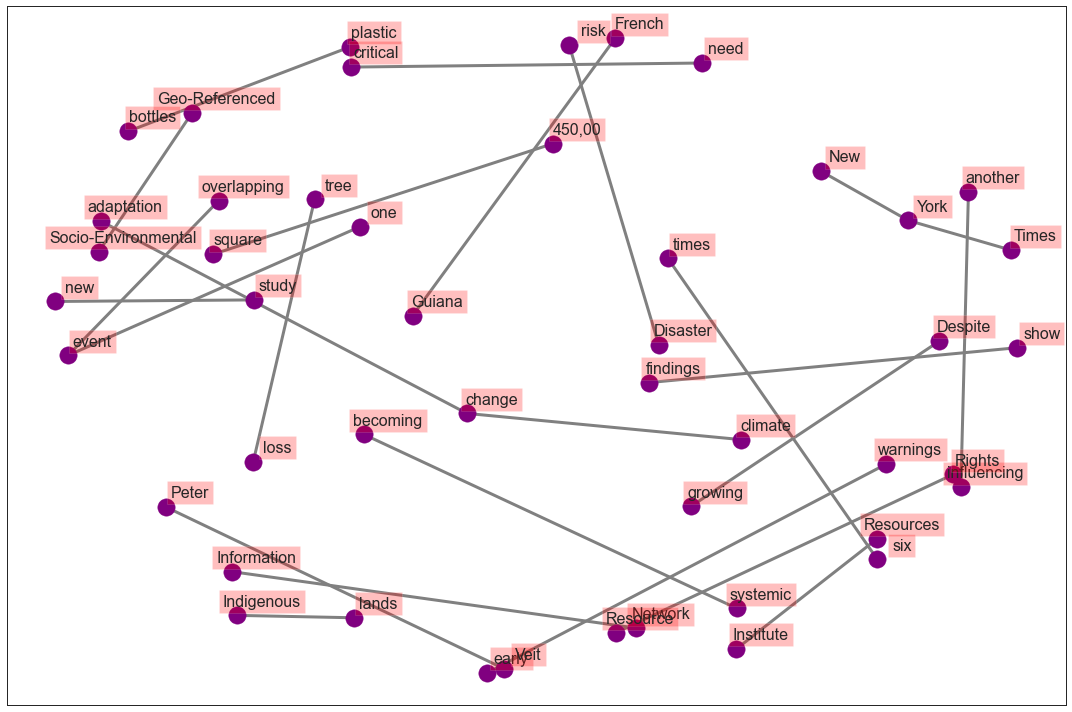

In [33]:
graph_plots(s_India,'Global')

In [3]:
import spacy
m = spacy.load("en_core_web_sm")

In [4]:
for i in range(len(df['Content'])):
    print(i)
    for ent in m(df['Content'][i]).ents:
        
        print(ent.text,ent.label_)

0
one CARDINAL
Mizutori PERSON
1
more than 20 percent PERCENT
Amazon ORG
450,00 square kilometers QUANTITY
the World Resources Institute ORG
WRI ORG
Amazon Geo-Referenced Socio-Environmental Information Network PRODUCT
1,131 CARDINAL
Amazon ORG
3,653 CARDINAL
French NORP
Guiana PERSON
at least 370 CARDINAL
Peru GPE
at least 30 CARDINAL
Amazonian NORP
88 CARDINAL
Bolivia GPE
Ecuador GPE
Peru GPE
at least three CARDINAL
Colombia GPE
Venezuela GPE
one to two CARDINAL
Amazonian NORP
years DATE
Peter Veit PERSON
WRI ORG
Land and Resource Rights Initiative ORG
Across the Amazon WORK_OF_ART
2
six CARDINAL
a year or two DATE
Today DATE
each year DATE
two CARDINAL
2016 DATE
2018 DATE
a few days DATE
six CARDINAL
John McGeehan PERSON
the University of Portsmouth ORG
the United Kingdom GPE
French NORP
April DATE
90 percent PERCENT
10 hours TIME
70 degrees Celsius QUANTITY
McGeehan PERSON
Carbios PRODUCT
the next year DATE
two CARDINAL
2018 DATE
one CARDINAL
PETase ORG
one CARDINAL
20 percent PERC

In [5]:
from spacy import displacy

In [6]:
for i in range(len(df['Content'])):
    doc = m(df['Content'][i])
    displacy.render(doc,style='ent')

In [7]:
options = {'ent':['ORG','GPE']}
for i in range(len(df['Content'])):
    doc = m(df['Content'][i])
    displacy.render(doc,style='ent',jupyter=True,options=options)